# Hurricane Damage Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=e0cbfcd0-8aa6-4081-8fc2-f11bd111f3f6
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 232MB/s]


In [3]:
!unzip -q hurricane_detector.zip

In [4]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Jun 23 14:05 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 21 21:47 sample_data/
drwxr-xr-x 4 root root     4096 Jun 23 14:05 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 23 14:05 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (92.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, f1_score, average_precision_score, precision_recall_curve, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.12.0


In [9]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

## Helper Functions

### Metrics

In [10]:
def plot_metrics(history):

  keys = history.history.keys()
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.capitalize()
    metric_name = [item for item in keys if metric in item and 'val_'+metric not in item][0]
    val_metric_name = [item for item in keys if 'val_'+metric in item][0]

    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
    plt.plot(history.epoch, history.history[val_metric_name], color='r',
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

def model_evaluation(y, predictions):

    print(classification_report(y, predictions))
    print('----------------------------------------------------------')
    accuracy = accuracy_score(y, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print('----------------------------------------------------------')
    precision = precision_score(y, predictions, average = "weighted")
    print("Precision: %.2f%%" % (precision * 100))
    print('----------------------------------------------------------')
    recall = recall_score(y, predictions, average = "weighted")
    print("Recall: %.2f%%" % (recall * 100))
    print('----------------------------------------------------------')

    cf = confusion_matrix(y, predictions)
    sns.heatmap(cf, annot=True, fmt='.0f');

### Utility functions to create dataset generators

In [11]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.2), label))
                        .map(lambda image, label: (tf.image.random_saturation(image, 0.5, 1.25), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


## Models

#### Spliting the data


In [12]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


#### Plots

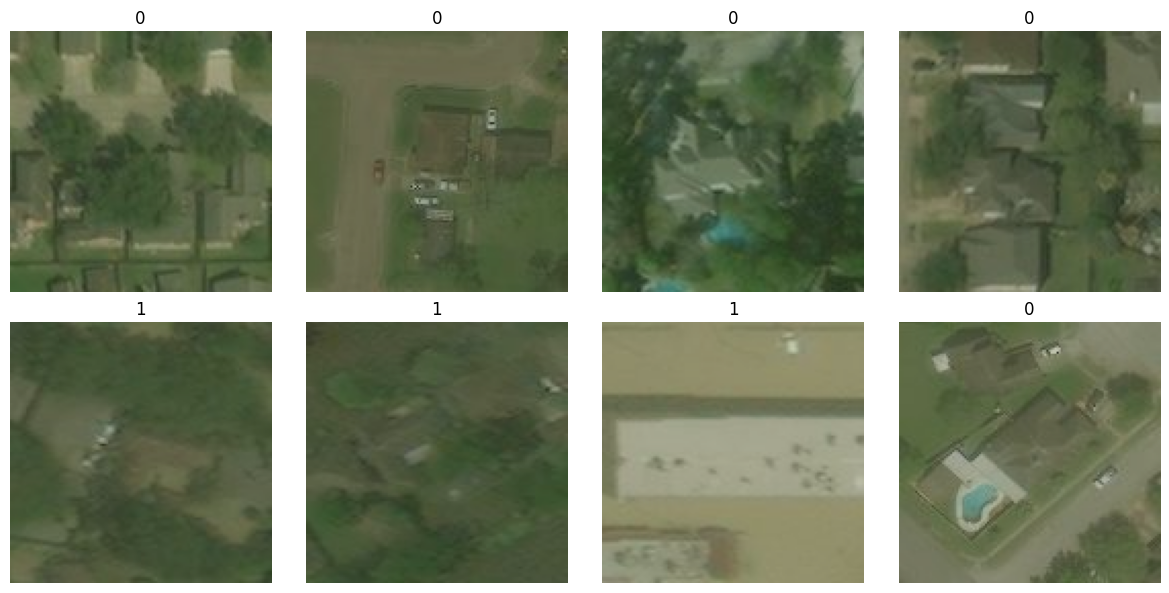

In [13]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

### Paper Model

Find original model [here](https://arxiv.org/pdf/1807.01688.pdf)

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape = (128, 128, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.1,0.3), width_factor=(0.1,0.3)),
    layers.experimental.preprocessing.Rescaling(1./255.)
  ]
)

In [15]:
paper_model = models.Sequential()

paper_model.add(data_augmentation)

paper_model.add(layers.Conv2D(32, (3,3), activation = "relu"))
paper_model.add(layers.BatchNormalization())
paper_model.add(layers.MaxPooling2D(pool_size = (2,2)))

paper_model.add(layers.Conv2D(64, (3,3), activation  = "relu"))
paper_model.add(layers.BatchNormalization())
paper_model.add(layers.MaxPooling2D(pool_size = (2,2)))

paper_model.add(layers.Conv2D(128, (3,3), activation  = "relu"))
paper_model.add(layers.BatchNormalization())
paper_model.add(layers.MaxPooling2D(pool_size = (2,2)))

paper_model.add(layers.Conv2D(128, (3,3), activation  = "relu"))
paper_model.add(layers.BatchNormalization())
paper_model.add(layers.MaxPooling2D(pool_size = (2,2)))

paper_model.add(layers.Flatten())

paper_model.add(layers.Dense(512, activation = "relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(1e-05)))
paper_model.add(layers.Dropout(rate=0.3))

paper_model.add(layers.Dense(1, activation = "sigmoid"))

paper_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
    )

early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

In [16]:
paper_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)      

In [17]:
paper_history = paper_model.fit(
    train_ds, epochs=100,
    validation_data=val_ds,
    callbacks = [early_stopping_cb]
)

y_true_paper, y_pred_paper = eval_model_on_test(paper_model)

Epoch 1/100
34/34 [==============================] - 19s 58ms/step - loss: 1.4518 - accuracy: 0.7268 - precision: 0.7167 - recall: 0.7288 - val_loss: 3.4816 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 2/100
34/34 [==============================] - 2s 31ms/step - loss: 0.4440 - accuracy: 0.8362 - precision: 0.8388 - recall: 0.8230 - val_loss: 4.4919 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 3/100
34/34 [==============================] - 2s 30ms/step - loss: 0.4627 - accuracy: 0.8528 - precision: 0.8630 - recall: 0.8305 - val_loss: 5.5217 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 4/100
34/34 [==============================] - 2s 31ms/step - loss: 0.3400 - accuracy: 0.8657 - precision: 0.8723 - recall: 0.8493 - val_loss: 7.5061 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 5/100
34/34 [==============================] - 2s 38ms/step - loss: 0.3764 - accuracy: 0.8537 - p

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<01:21,  1.16it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<00:47,  1.98it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:36,  2.55it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:30,  3.04it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:26,  3.42it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:25,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:02<00:23,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:21,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:18,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:17,  5.01it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:15,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:14,  5.62it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:13,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:13,  6.21it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:13,  6.10it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:03<00:13,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:12,  6.38it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:12,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:04<00:12,  6.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:11,  6.42it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:11,  6.30it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:11,  6.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:11,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:05<00:11,  6.38it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:11,  6.23it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:11,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:11,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:10,  6.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:10,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:10,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:10,  6.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:09,  6.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:09,  6.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:09,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:09,  6.31it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.49it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:07<00:08,  6.64it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:07<00:08,  6.80it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:08,  6.69it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:08,  6.63it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:08,  6.77it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:07,  6.88it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:07,  7.03it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:08<00:07,  7.15it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:08<00:07,  7.08it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:07,  6.68it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:07,  6.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:07,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:07,  6.40it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:09<00:07,  6.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:06,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  6.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:10<00:05,  6.77it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:05,  6.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:05,  6.56it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  6.52it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:05,  6.67it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:10<00:04,  6.77it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:04,  6.73it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:04,  6.84it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:04,  6.48it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.39it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.61it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:11<00:04,  6.74it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:11<00:03,  6.96it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:03,  7.04it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:12<00:03,  5.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:03,  5.19it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:03,  5.13it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:03,  5.11it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:03,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:03,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:14<00:03,  4.76it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:03,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  4.60it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:02,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:15<00:02,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:15<00:01,  5.36it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:15<00:01,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:01,  6.25it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:00,  6.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  6.52it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:16<00:00,  6.63it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:16<00:00,  6.77it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:16<00:00,  7.13it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:16<00:00,  7.43it/s]

3/3 [==============================] - 0s 88ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6333
           1       0.84      0.98      0.90      5895

    accuracy                           0.90     12228
   macro avg       0.91      0.90      0.90     12228
weighted avg       0.91      0.90      0.90     12228

----------------------------------------------------------
Accuracy: 90.10%
----------------------------------------------------------
Precision: 91.13%
----------------------------------------------------------
Recall: 90.10%
----------------------------------------------------------


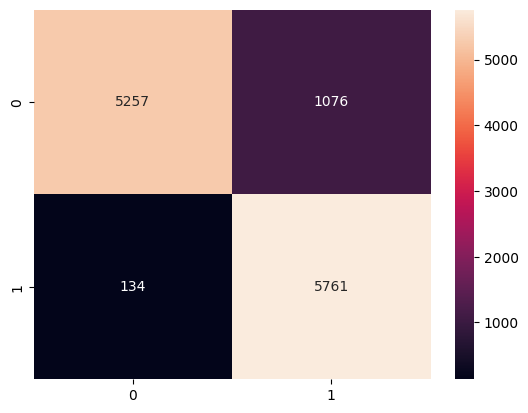

In [18]:
y_pred_labels_paper = np.array([1 if p > 0.5 else 0 for p in y_pred_paper])
model_evaluation(y_true_paper, y_pred_labels_paper)

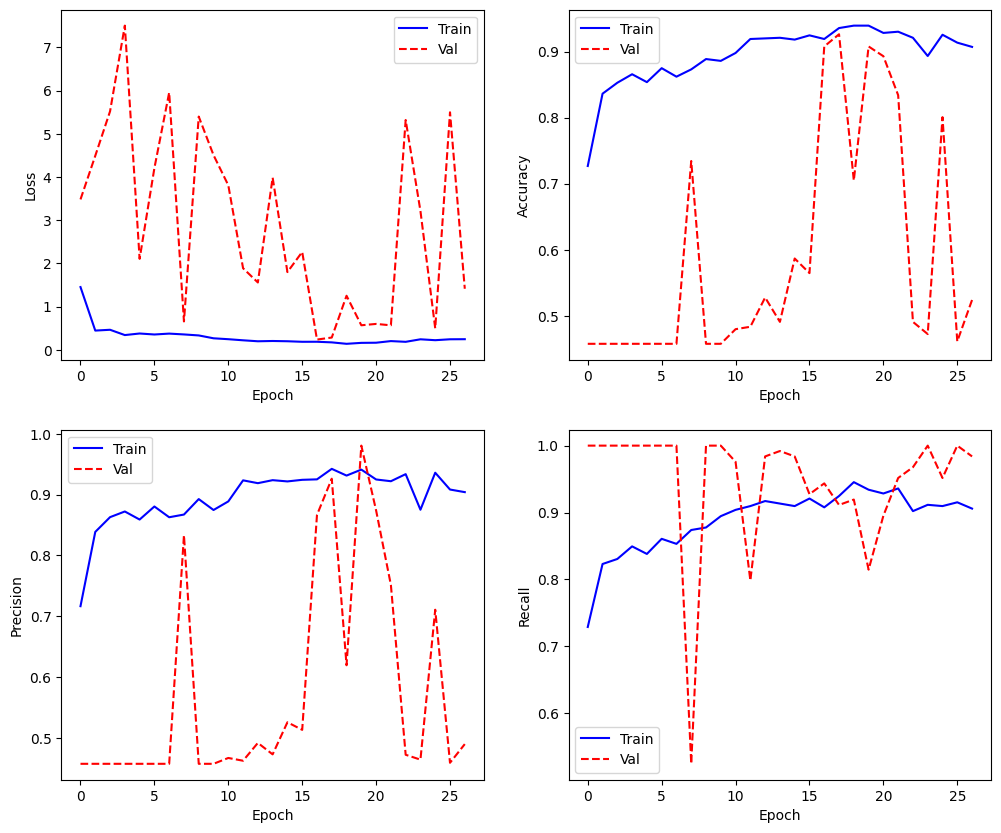

In [19]:
plot_metrics(paper_history)

### Small Model

In [20]:
model = models.Sequential()

model.add(data_augmentation)

model.add(layers.Conv2D(32, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))

model.add(layers.Conv2D(64, (3,3), activation  = "relu"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = "relu"))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(512, activation = "relu"))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
    )

early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 57600)            

In [22]:
history = model.fit(
    train_ds, epochs=300,
    validation_data=val_ds,
    callbacks = [early_stopping_cb]
)

y_true, y_pred = eval_model_on_test(model)

Epoch 1/300
34/34 [==============================] - 7s 69ms/step - loss: 0.6964 - accuracy: 0.5336 - precision: 0.5594 - recall: 0.2128 - val_loss: 0.6261 - val_accuracy: 0.7269 - val_precision: 0.9630 - val_recall: 0.4194
Epoch 2/300
34/34 [==============================] - 3s 34ms/step - loss: 0.6638 - accuracy: 0.6201 - precision: 0.6014 - recall: 0.6591 - val_loss: 0.7709 - val_accuracy: 0.5424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
34/34 [==============================] - 2s 27ms/step - loss: 0.6667 - accuracy: 0.6136 - precision: 0.5996 - recall: 0.6290 - val_loss: 0.6590 - val_accuracy: 0.5867 - val_precision: 0.5270 - val_recall: 0.9435
Epoch 4/300
34/34 [==============================] - 2s 30ms/step - loss: 0.6469 - accuracy: 0.5750 - precision: 0.5714 - recall: 0.5198 - val_loss: 0.5636 - val_accuracy: 0.7934 - val_precision: 0.9595 - val_recall: 0.5726
Epoch 5/300
34/34 [==============================] - 2s 28ms/step - loss: 0.6769 - accuracy: 0.6

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:42,  2.22it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:26,  3.52it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:21,  4.36it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:18,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:16,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:15,  5.87it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:15,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:13,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:13,  6.39it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:13,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.02it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:13,  6.32it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:12,  6.38it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:12,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:12,  6.56it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:02<00:12,  6.37it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:11,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:11,  6.68it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:11,  6.86it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:03<00:11,  6.51it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:03<00:11,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:03<00:11,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:11,  6.42it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:10,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:04<00:10,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:04<00:10,  6.47it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:04<00:11,  5.80it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:12,  5.25it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:13,  4.93it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:13,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:13,  4.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:05<00:12,  4.78it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:12,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:12,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:12,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:12,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:11,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:07<00:11,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:07<00:09,  5.52it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:09,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:08,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:08,  6.02it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:08,  6.30it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:08<00:07,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:08<00:07,  6.36it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:08<00:07,  6.25it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:07,  6.21it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:07,  6.53it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:06,  6.76it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:09<00:06,  6.52it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:06,  6.45it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:06,  6.25it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:06,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:06,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:06,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:09<00:05,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:05,  6.73it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:05,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:05,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:10<00:04,  6.81it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:10<00:04,  6.68it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:10<00:05,  6.38it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:04,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:04,  6.78it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.58it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:11<00:03,  6.83it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:11<00:03,  7.07it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:11<00:03,  7.13it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:11<00:03,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  7.09it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  6.66it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:12<00:03,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:12<00:03,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:12<00:02,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:12<00:02,  6.26it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  6.19it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  6.49it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:03,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:13<00:02,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:13<00:02,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:02,  5.55it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:01,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:14<00:01,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:14<00:01,  6.44it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:14<00:01,  6.87it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:14<00:00,  7.06it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:14<00:00,  7.24it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:15<00:00,  7.26it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:15<00:00,  7.24it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:15<00:00,  7.43it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:15<00:00,  7.26it/s]

3/3 [==============================] - 0s 7ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:15<00:00,  6.07it/s]


              precision    recall  f1-score   support

           0       0.82      0.95      0.88      6333
           1       0.93      0.78      0.85      5895

    accuracy                           0.87     12228
   macro avg       0.88      0.86      0.87     12228
weighted avg       0.88      0.87      0.87     12228

----------------------------------------------------------
Accuracy: 86.73%
----------------------------------------------------------
Precision: 87.56%
----------------------------------------------------------
Recall: 86.73%
----------------------------------------------------------


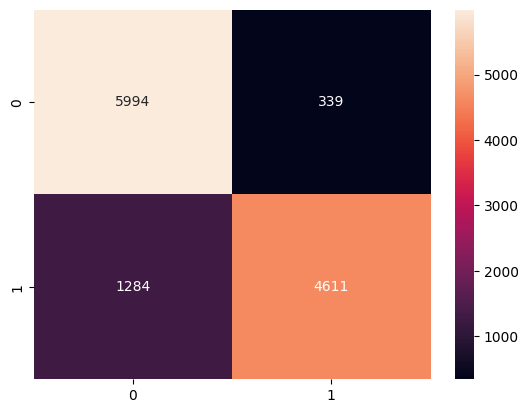

In [23]:
y_pred_labels = np.array([1 if p > 0.5 else 0 for p in y_pred]) # y_pred > 0.5
model_evaluation(y_true, y_pred_labels)

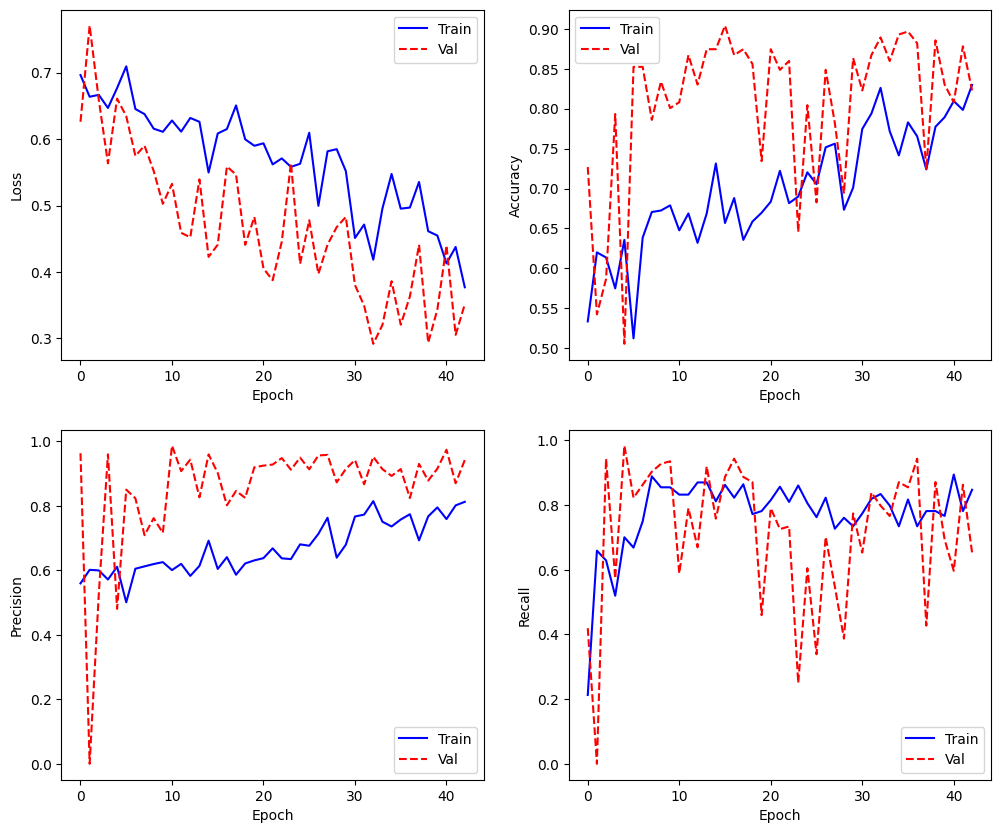

In [24]:
plot_metrics(history)

## ResNet - Transfer Learning

In [25]:
base_ResNet = tf.keras.applications.ResNet50(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [26]:
base_ResNet.trainable = False

In [27]:
inputs = tf.keras.Input(shape=(128, 128, 3))

aug_img = data_augmentation(inputs)

pre_img = tf.keras.applications.resnet.preprocess_input(aug_img)

res_model_fm = base_ResNet(pre_img, training = False)

# This is our part of the model
feature_vec = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)

dense1 = tf.keras.layers.Dense(512, activation = "relu")(feature_vec)
dropout1 = tf.keras.layers.Dropout(0.3)(dense1)

dense2 = tf.keras.layers.Dense(512, activation = "relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(0.3)(dense2)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout2)

tl_model = tf.keras.Model(inputs, outputs)

In [28]:
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [29]:
tl_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
    )

early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

In [30]:
tl_history = tl_model.fit(
    train_ds, epochs=300,
    validation_data=val_ds,
    callbacks = [early_stopping_cb]
)

y_true_tl, y_pred_tl = eval_model_on_test(tl_model)

Epoch 1/300
34/34 [==============================] - 11s 151ms/step - loss: 0.7277 - accuracy: 0.4968 - precision: 0.4835 - recall: 0.4407 - val_loss: 0.7008 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 2/300
34/34 [==============================] - 2s 51ms/step - loss: 0.7198 - accuracy: 0.5106 - precision: 0.4990 - recall: 0.4539 - val_loss: 0.7012 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 3/300
34/34 [==============================] - 3s 52ms/step - loss: 0.7179 - accuracy: 0.4931 - precision: 0.4807 - recall: 0.4689 - val_loss: 0.7021 - val_accuracy: 0.4576 - val_precision: 0.4576 - val_recall: 1.0000
Epoch 4/300
34/34 [==============================] - 3s 56ms/step - loss: 0.6987 - accuracy: 0.5281 - precision: 0.5158 - recall: 0.5518 - val_loss: 0.6736 - val_accuracy: 0.5424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/300
34/34 [==============================] - 3s 59ms/step - loss: 0.6880 - accuracy: 0

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 2s 47ms/step


Predicting on Test Data:   1%|          | 1/96 [00:02<03:36,  2.28s/it]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:52,  1.20s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:03<01:18,  1.19it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:03<01:01,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:03<00:47,  1.92it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:04<00:38,  2.33it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:04<00:32,  2.73it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:04<00:28,  3.09it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:04<00:25,  3.38it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:23,  3.66it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:05<00:21,  3.87it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:05<00:20,  4.01it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:05<00:20,  4.10it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:19,  4.14it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:06<00:19,  4.13it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:06<00:19,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:18,  4.22it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:18,  4.21it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:07<00:18,  4.27it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:07<00:17,  4.24it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:18,  4.16it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:18,  4.07it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:08<00:17,  4.16it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:08<00:16,  4.25it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:08<00:16,  4.23it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:16,  4.20it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:09<00:16,  4.13it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:09<00:16,  4.13it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:16,  4.07it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:16,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:15,  4.07it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:10<00:15,  4.16it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:15,  4.12it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:14,  4.18it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:14,  4.23it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:11<00:14,  4.19it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:14,  4.14it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:14,  4.11it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:13,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:12<00:13,  4.13it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:12,  4.25it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:12,  4.18it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:12<00:12,  4.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:13<00:13,  3.87it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:14,  3.63it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:14,  3.49it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:14<00:14,  3.49it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:14<00:13,  3.56it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:14<00:13,  3.52it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:13,  3.39it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:15<00:13,  3.43it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:15<00:12,  3.63it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:15<00:11,  3.78it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:15<00:11,  3.81it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:16<00:10,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:16<00:10,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:09,  4.02it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:16<00:09,  4.04it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:17<00:09,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:08,  4.10it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:08,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:08,  4.15it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:08,  4.11it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:07,  4.21it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:07,  4.30it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:07,  4.24it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:19<00:06,  4.19it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:06,  4.15it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:06,  4.17it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:19<00:06,  4.18it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  4.11it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:05,  4.12it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:05,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:20<00:05,  4.10it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:04,  4.21it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:04,  4.14it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:21<00:04,  4.23it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:21<00:04,  4.19it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:21<00:04,  4.14it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:03,  4.11it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  4.08it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:22<00:03,  4.07it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:22<00:03,  4.10it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:02,  4.11it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  4.22it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  4.23it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:23<00:02,  4.23it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.22it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.28it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.30it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:24<00:01,  4.43it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:25<00:00,  4.50it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  4.37it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.16it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  4.04it/s]

3/3 [==============================] - 2s 256ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:27<00:00,  3.45it/s]


              precision    recall  f1-score   support

           0       0.81      0.72      0.76      6333
           1       0.73      0.82      0.77      5895

    accuracy                           0.77     12228
   macro avg       0.77      0.77      0.77     12228
weighted avg       0.77      0.77      0.77     12228

----------------------------------------------------------
Accuracy: 76.90%
----------------------------------------------------------
Precision: 77.39%
----------------------------------------------------------
Recall: 76.90%
----------------------------------------------------------


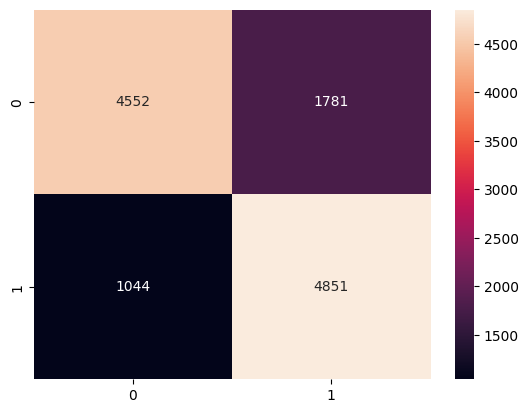

In [31]:
y_pred_labels_tl = np.array([1 if p > 0.5 else 0 for p in y_pred_tl]) # y_pred > 0.5
model_evaluation(y_true_tl, y_pred_labels_tl)

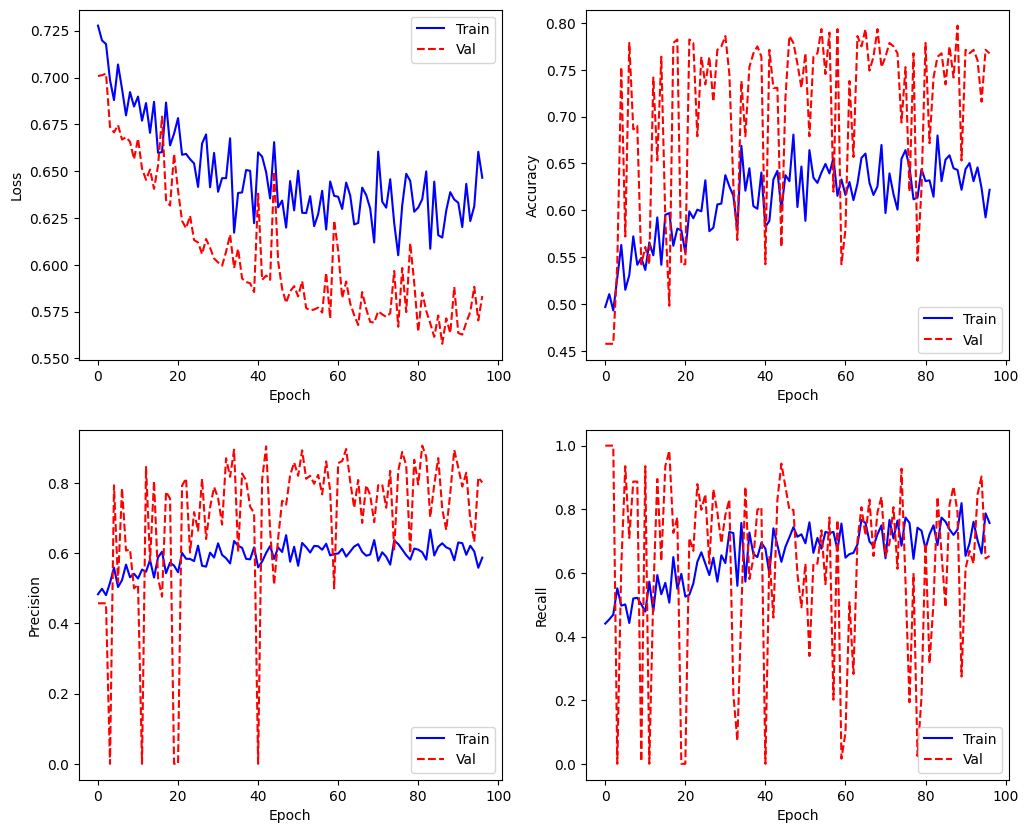

In [32]:
plot_metrics(tl_history)

# Mehra's Models

In [33]:
dense4 = tf.keras.layers.Dense(256, activation = "relu")(feature_vec)
dropout4 = tf.keras.layers.Dropout(0.3)(dense1)

mh_outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout4)

mh_model = tf.keras.Model(inputs, mh_outputs)

In [34]:
mh_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
    )

early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)

In [35]:
mh_history = mh_model.fit(
    train_ds, epochs=300,
    validation_data=val_ds,
    callbacks = [early_stopping_cb]
)

y_true_mh, y_pred_mh = eval_model_on_test(mh_model)

Epoch 1/300
34/34 [==============================] - 8s 94ms/step - loss: 0.6891 - accuracy: 0.5235 - precision: 0.5135 - recall: 0.4670 - val_loss: 0.6739 - val_accuracy: 0.5424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
34/34 [==============================] - 3s 60ms/step - loss: 0.6798 - accuracy: 0.5511 - precision: 0.5447 - recall: 0.4934 - val_loss: 0.6669 - val_accuracy: 0.5424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
34/34 [==============================] - 3s 56ms/step - loss: 0.6755 - accuracy: 0.5768 - precision: 0.5831 - recall: 0.4689 - val_loss: 0.6650 - val_accuracy: 0.7675 - val_precision: 0.8020 - val_recall: 0.6532
Epoch 4/300
34/34 [==============================] - 3s 56ms/step - loss: 0.6665 - accuracy: 0.6237 - precision: 0.6151 - recall: 0.6139 - val_loss: 0.6619 - val_accuracy: 0.7860 - val_precision: 0.8056 - val_recall: 0.7016
Epoch 5/300
34/34 [==============================] - 3s 67ms/step - loss: 0.6727 - accur

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 45ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:25,  1.53s/it]

4/4 [==============================] - 0s 42ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<01:15,  1.25it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<00:52,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:40,  2.27it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:33,  2.69it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:29,  3.02it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:27,  3.27it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:25,  3.49it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:23,  3.73it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:22,  3.83it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:21,  3.89it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:21,  3.91it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:20,  4.03it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:04<00:20,  4.07it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:19,  4.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:19,  4.20it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:05<00:18,  4.27it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:05<00:18,  4.22it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:05<00:18,  4.26it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:17,  4.24it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:06<00:18,  4.15it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:06<00:17,  4.21it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:06<00:17,  4.29it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:07<00:16,  4.26it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:07<00:16,  4.21it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:07<00:16,  4.25it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:07<00:15,  4.31it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:08<00:17,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:08<00:17,  3.74it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:08<00:18,  3.66it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:18,  3.57it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:09<00:18,  3.45it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:09<00:18,  3.36it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:09<00:18,  3.33it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:18,  3.32it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:10<00:16,  3.58it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:10<00:15,  3.78it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:10<00:14,  3.93it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:14,  3.94it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:11<00:14,  3.96it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:11<00:13,  4.06it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:11<00:12,  4.18it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:12<00:12,  4.16it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:12<00:12,  4.11it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:12<00:12,  4.08it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:12<00:12,  4.16it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:13<00:11,  4.24it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:13<00:11,  4.24it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:13<00:10,  4.28it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:13<00:10,  4.32it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:14<00:10,  4.15it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:14<00:10,  4.13it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:14<00:10,  4.11it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:14<00:10,  4.04it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:15<00:10,  4.08it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:15<00:09,  4.16it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:15<00:09,  4.23it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:15<00:08,  4.28it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:15<00:08,  4.23it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:16<00:08,  4.26it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:16<00:08,  4.19it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:16<00:08,  4.18it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:17<00:10,  3.04it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:17<00:09,  3.26it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:17<00:08,  3.45it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:17<00:08,  3.61it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:18<00:07,  3.73it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:18<00:07,  3.82it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:18<00:06,  3.94it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:18<00:06,  4.05it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:19<00:06,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:19<00:06,  3.97it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:19<00:05,  3.91it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:19<00:05,  3.94it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:20<00:05,  3.92it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:20<00:05,  3.69it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:20<00:05,  3.49it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:21<00:05,  3.45it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:21<00:05,  3.31it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:21<00:04,  3.37it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:04,  3.32it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:22<00:04,  3.27it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:22<00:03,  3.29it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:22<00:03,  3.49it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  3.70it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  3.81it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:23<00:02,  3.91it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:23<00:01,  4.11it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.28it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.27it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:24<00:01,  4.33it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:24<00:00,  4.47it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:24<00:00,  4.47it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.45it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  4.47it/s]

3/3 [==============================] - 1s 29ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      6333
           1       0.80      0.75      0.77      5895

    accuracy                           0.79     12228
   macro avg       0.79      0.79      0.79     12228
weighted avg       0.79      0.79      0.79     12228

----------------------------------------------------------
Accuracy: 78.75%
----------------------------------------------------------
Precision: 78.80%
----------------------------------------------------------
Recall: 78.75%
----------------------------------------------------------


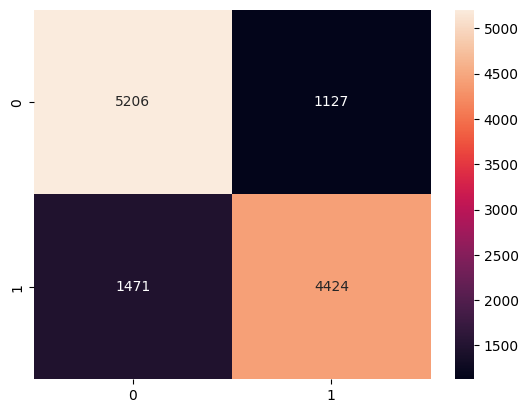

In [36]:
y_pred_labels_mh = np.array([1 if p > 0.5 else 0 for p in y_pred_mh])
model_evaluation(y_true_mh, y_pred_labels_mh)